In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import esmlab

import warnings
warnings.filterwarnings("ignore")

### Reading in Data

In [2]:
dir = '/glade/p/cesm/lmwg_dev/dll/CMIP6_CO2/CatCO2data/'
#note: 'CNRM-ESM2-1' uses r1k1p1f2 -- does this mean it's different in some way?

BCC_CSM2 = xr.open_dataset(dir + "co2_Amon_BCC-CSM2-MR_historical_r1i1p1f1_gn_185001-201412.nc")
BCC_ESM1 = xr.open_dataset(dir + "co2_Amon_BCC-ESM1_historical_r1i1p1f1_gn_185001-201412.nc")
CNRM     = xr.open_dataset(dir + "co2_Amon_CNRM-ESM2-1_historical_r1i1p1f2_gr_185001-201412.nc")
GFDL     = xr.open_dataset(dir + "co2_Amon_GFDL-ESM4_historical_r1i1p1f1_gr1_185001-201412.nc")
MRI      = xr.open_dataset(dir + "co2_Amon_MRI-ESM2-0_historical_r1i1p1f1_gn_185001-201412.nc")
NorESM   = xr.open_dataset(dir + "co2_Amon_NorESM2-MM_historical_r1i1p1f1_gn_185001-201412.nc")
CESM     = xr.open_dataset(dir + "co2_Amon_CESM2_historical_r1i1p1f1_gn_185001-201412.nc")


### Updating coordinates so math functions work properly

In [3]:
#coordinates are already properly set for CNRM
BCC_CSM2 = BCC_CSM2.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
BCC_ESM1 = BCC_ESM1.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
#CNRM     = CNRM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
GFDL     = GFDL.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
MRI      = MRI.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
NorESM   = NorESM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])
CESM     = CESM.set_coords(['time_bnds', 'lat_bnds', 'lon_bnds'])

In [ ]:
#CESM

### Setting up dictionary for easier manipulation

In [4]:
co2_ds = dict()
co2_ds['BCC_CSM2']  = BCC_CSM2.co2
co2_ds['BCC_ESM1']  = BCC_ESM1.co2
co2_ds['CNRM']      = CNRM.co2
co2_ds['GFDL']      = GFDL.co2
co2_ds['MRI']       = MRI.co2
co2_ds['NorESM']    = NorESM.co2
co2_ds['CESM']      = CESM.co2

In [5]:
co2_ds

{'BCC_CSM2': <xarray.DataArray 'co2' (time: 1980, plev: 19, lat: 160, lon: 320)>
 [1926144000 values with dtype=float32]
 Coordinates:
   * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
   * plev     (plev) float64 1e+05 9.25e+04 8.5e+04 7e+04 ... 1e+03 500.0 100.0
   * lat      (lat) float64 -89.14 -88.03 -86.91 -85.79 ... 86.91 88.03 89.14
   * lon      (lon) float64 0.0 1.125 2.25 3.375 4.5 ... 355.5 356.6 357.8 358.9
 Attributes:
     standard_name:  mole_fraction_of_carbon_dioxide_in_air
     long_name:      Mole Fraction of CO2
     comment:        Mole fraction is used in the construction mole_fraction_o...
     units:          mol mol-1
     original_name:  CO2VMR
     cell_methods:   time: mean (interval: 5 minutes)
     cell_measures:  area: areacella,
 'BCC_ESM1': <xarray.DataArray 'co2' (time: 1980, plev: 19, lat: 64, lon: 128)>
 [308183040 values with dtype=float32]
 Coordinates:
   * time     (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
 

In [6]:
#conversion of CO2 from mol/mol to ppm
convert = 10.0**6 * 28.966/44.0

### Setting up arrays to subset points

In [7]:
#Locations: Mauna Loa, Barrow, Niwot
lats=np.array([71.3,19.5,40.1])
lons=np.array([360-156.61,360-155.6,360-105.6])

### Testing model and location subsets to determine maximum CO2 concentrations 

#### Why do most models have nans at Niwot at lowest level? There are similar problems with other locations & levels
#### Why are values ~100 ppm lower than observations? 

In [9]:
#Locations: Mauna Loa=0, Barrow=1, Niwot=2
x=1
test = []
test = co2_ds['CESM'].sel(lat=lats[x],lon=lons[x], method='nearest')
#test = co2_ds['CESM'].sel(lat=slice(30,90))
test = test.sel(time=slice("2010", "2015"))
test = test.isel(plev=0)*convert
#test.max()

## Max val at NWT is 289.86, lowest level with available data is plev=3
## Max val at MLO is 291.16 (plev=0)
## Max val at BRW is 288.55 (plev=1)

NOTE: May want to consider remaking Graven plot
change in CO2 amplitude vs CO2 amplitude over certain time period. 

NOTE: Values for CESM aren't consistent with other analysis. Incorrect calculations? 
other possible differences: processed for diff. atmosphere layers


### Pulling out site locations

In [10]:
ml_nbp = {}
bar_nbp = {}
nwt_nbp = {}

ml_nbp_mean = {}
ml_nbp_std = {}
bar_nbp_mean = {}
bar_nbp_std = {}
nwt_nbp_mean = {}
nwt_nbp_std = {}

for sim_name, data in co2_ds.items():
    ml = data.sel(lat=19.5,lon=204.4, method='nearest')
    ml_nbp[sim_name] = ml.isel(plev=0) * convert
    bar = data.sel(lat=71.3,lon=203.4, method='nearest')
    bar_nbp[sim_name] = bar.isel(plev=0) * convert
    nwt = data.sel(lat=40.1,lon=254.4, method='nearest')
    nwt_nbp[sim_name] = nwt.isel(plev=0) * convert

### Calculating amplitude time series and 2000-2015 mean and error for each location

In [11]:
# Mauna Loa
for sim_name, data in ml_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    ml_nbp[sim_name] = co2amp
    co2_mean_amp = co2amp.sel(time=slice("2000","2015")).mean()
    ml_nbp_mean[sim_name] = co2_mean_amp
    co2_std_amp = co2amp.sel(time=slice("2000","2015")).std()
    ml_nbp_std[sim_name] = co2_std_amp

In [12]:
# Barrow
for sim_name, data in bar_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    bar_nbp[sim_name] = co2amp
    co2_mean_amp = co2amp.sel(time=slice("2000","2015")).mean()
    bar_nbp_mean[sim_name] = co2_mean_amp
    co2_std_amp = co2amp.sel(time=slice("2000","2015")).std()
    bar_nbp_std[sim_name] = co2_std_amp

In [13]:
# Niwot Ridge
for sim_name, data in nwt_nbp.items():
    co2amp = data.resample(time="Y").max() - data.resample(time="Y").min()
    nwt_nbp[sim_name] = co2amp
    co2_mean_amp = co2amp.sel(time=slice("2000","2015")).mean()
    nwt_nbp_mean[sim_name] = co2_mean_amp
    co2_std_amp = co2amp.sel(time=slice("2000","2015")).std()
    nwt_nbp_std[sim_name] = co2_std_amp

In [ ]:
#ml_nbp['CESM']
#nwt_nbp_mean['CESM']

### Plotting mean amplitude averaged for 2000-2015
Only plots values for Barrow, other locations are nans for most (not all) models. Some models low/nans for Barrow
CESM mean amplitude here seems lower than in my other plots (should be ~15 ppm)

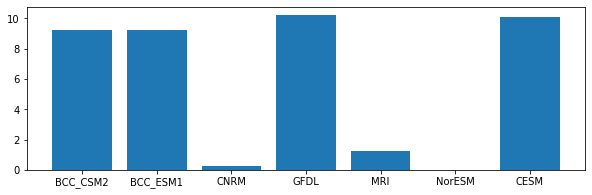

In [14]:
#Barrow
plt.figure(figsize=(10,3))
plt.bar(*zip(*bar_nbp_mean.items()))
plt.show()

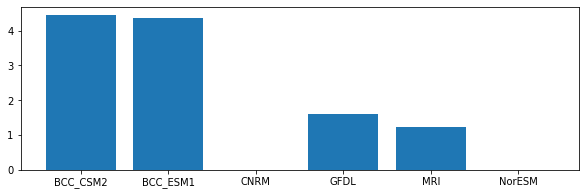

In [15]:
#Mauna Loa
plt.figure(figsize=(10,3))
plt.bar(*zip(*ml_nbp_mean.items()))
plt.show()

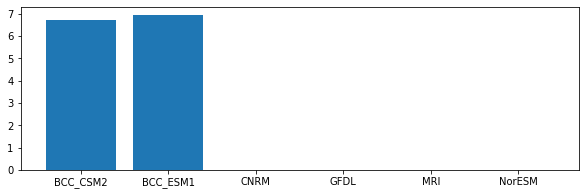

In [16]:
#Niwot
plt.figure(figsize=(10,3))
plt.bar(*zip(*nwt_nbp_mean.items()))
plt.show()

In [ ]:
#This needs to be cleaned up
fig = plt.figure(figsize=(10,3))
for i,(site, data) in enumerate (nwt_nbp.items()):
    ax = fig.add_subplot(2,4,i+1)
    data.plot(color='darkorange', label='CESM1')
#    plt.title(labels[i])
    plt.ylabel(r'CO$_2$ amplitude [ppm]')
    plt.xlabel('Year')
    plt.ylim(0,12)
    plt.tight_layout()
#    plt.text(0.05, 0.93,panel[i], fontsize=14,
#     ha='center', va='center', transform=plt.gca().transAxes)

In [ ]:
for sim_name, data in co2_ds.items():
    co2amp  = data.resample(time="Y").max() - data.resample(time="Y").min()
#    co2amp  = co2amp * convert
    co2_ds[sim_name] = co2amp

In [ ]:
co2_ds